In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import os

from tqdm import tqdm
import numpy as np
import h5py

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
from aatw.units_constants import *
from aatw.telescopes import *

from config import config_dict, intermediates_dir

## 1. Reach

In [69]:
config_name = 'HIRAX-1024-nnu30-nra3-ndec3'
config = config_dict[config_name]

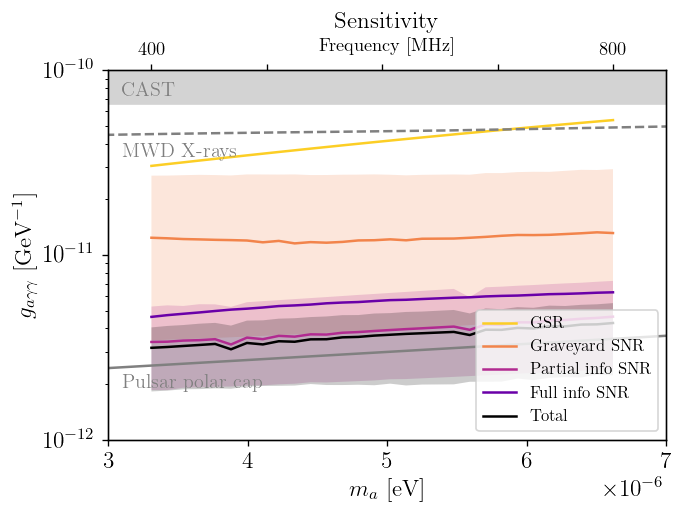

In [82]:
plot_names = ['gsr', 'snrg', 'snrp', 'snrf', 'total']
plot_all_samples = False

label_dict = {
    'gsr' : 'GSR',
    'snrg' : 'Graveyard SNR',
    'snrp' : 'Partial info SNR',
    'snrfp' : 'Catalogue SNR',
    'snrf' : 'Full info SNR',
    'total' : 'Total',
}
color_dict = {
    'gsr' : cms['plasma'](0.9),
    'snrg' : cms['plasma'](0.7),
    'snrp' : cms['plasma'](0.4),
    'snrfp' : cms['plasma'](0.3),
    'snrf' : cms['plasma'](0.2),
    'total' : 'k',
}
telescope = config['telescope']

fig, ax = plt.subplots()

for pn in plot_names:
    with h5py.File(f"../outputs/plot_data/{config_name}/{pn}.h5", 'r') as hf:
        nu_arr = np.delete(hf['nu'][:], 18, axis=0)
        gagg_arr = np.delete(hf['gagg'][:], 18, axis=1)
        
        ma_arr = 4*PI*hbar*nu_arr / eV
        
        if gagg_arr.shape[0] == 1:
            ax.plot(ma_arr, gagg_arr[0], color=color_dict[pn], label=label_dict[pn])
        else:
            if plot_all_samples:
                for i, gagg_sample in enumerate(gagg_arr):
                    ax.plot(ma_arr, gagg_sample, color=color_dict[pn], alpha=0.1,
                            label=(label_dict[pn] if i==0 else None), zorder=-1)
            else:
                ax.plot(ma_arr, np.median(gagg_arr, axis=0), color=color_dict[pn], label=label_dict[pn])
                ax.fill_between(ma_arr, np.quantile(gagg_arr, 0.95, axis=0), np.quantile(gagg_arr, 0.05, axis=0),
                                alpha=0.2, facecolor=color_dict[pn], edgecolor='none')

ax.fill_between([1e-6, 1e-5], gagg_CAST/invGeV, 1e-8, color='lightgray')
ax.text(3.1e-6, 7.3e-11, 'CAST', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/PulsarPolarCap.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-')
ax.text(3.1e-6, 1.9e-12, 'Pulsar polar cap', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDXrays.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='--')
ax.text(3.1e-6, 3.4e-11, 'MWD X-rays', color='gray')

ax.set(xlim=(3e-6, 7e-6), ylim=(1e-12, 1e-10), yscale='log')
ax.set(xlabel='$m_a$ [eV]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', title='Sensitivity')

ax_top = ax.twiny()
ax_top.set_xlim(np.array(ax.get_xlim()) * eV / (4*PI*hbar))
ax_top.set_xlabel('Frequency [MHz]', fontsize=11)
ax_top.set_xticks([400, 500, 600, 700, 800])
ax_top.set_xticklabels(['400', '', '', '', '800'], fontsize=11)
ax_top.xaxis.set_label_coords(0.5, 1.05)

ax.legend(loc='lower right', fontsize=10)
fig.savefig('../outputs/HIRAX-1024_reach.pdf')

### 1.2 Different telescopes

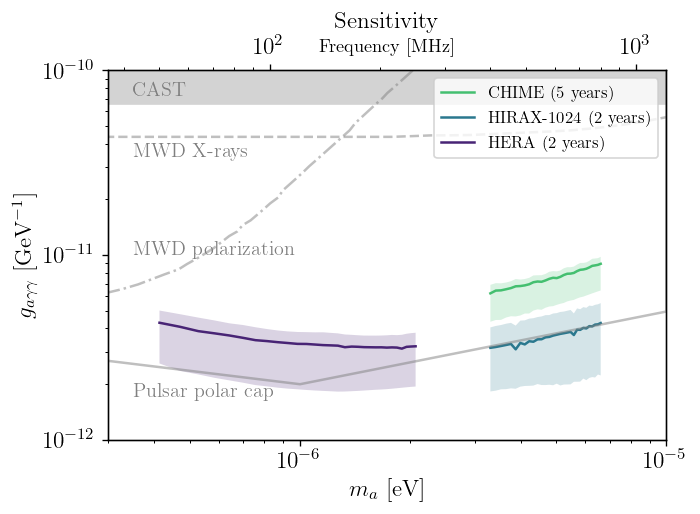

In [12]:
telescopes = [CHIME, HIRAX_1024, HERA]
plot_all_samples = False

label_dict = {
    'CHIME' : 'CHIME (5 years)',
    'HIRAX-1024' : 'HIRAX-1024 (2 years)',
    'HERA' : 'HERA (2 years)',
}
color_dict = {
    'CHIME' : cms['viridis'](0.7),
    'HIRAX-1024' : cms['viridis'](0.4),
    'HERA' : cms['viridis'](0.1),
}

fig, ax = plt.subplots()

postfix = 'nnu30-nra3-ndec3'

for telescope in telescopes:
    with h5py.File(f"../outputs/plot_data/{telescope.name}-{postfix}/total.h5", 'r') as hf:
        if telescope.name == 'HIRAX-1024':
            nu_arr = np.delete(hf['nu'][:], 18, axis=0)
            gagg_arr = np.delete(hf['gagg'][:], 18, axis=1)
        elif telescope.name == 'HERA':
            nu_arr = np.delete(hf['nu'][:], 20, axis=0)
            gagg_arr = np.delete(hf['gagg'][:], 20, axis=1)
        else:
            nu_arr = np.array(hf['nu'][:])
            gagg_arr = np.array(hf['gagg'][:])
        
        ma_arr = 4*PI*hbar*nu_arr / eV
        color = color_dict[telescope.name]
        label = label_dict[telescope.name]
        
        if gagg_arr.shape[0] == 1:
            ax.plot(ma_arr, gagg_arr[0], color=color, label=label_dict[telescope.name])
        else:
            if plot_all_samples:
                for i, gagg_sample in enumerate(gagg_arr):
                    ax.plot(ma_arr, gagg_sample, color=color, alpha=0.1,
                            label=(label if i==0 else None), zorder=-1)
            else:
                ax.plot(ma_arr, np.median(gagg_arr, axis=0), color=color, label=label)
                ax.fill_between(ma_arr, np.quantile(gagg_arr, 0.95, axis=0), np.quantile(gagg_arr, 0.05, axis=0),
                                alpha=0.2, facecolor=color, edgecolor='none')

ax.fill_between([1e-8, 1e-4], gagg_CAST/invGeV, 1e-8, color='lightgray')
ax.text(3.5e-7, 7.3e-11, 'CAST', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/PulsarPolarCap.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-', alpha=0.5)
ax.text(3.5e-7, 1.7e-12, 'Pulsar polar cap', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDPolarisation.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-.', alpha=0.5)
ax.text(3.5e-7, 1.0e-11, 'MWD polarization', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDXrays.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='--', alpha=0.5)
ax.text(3.5e-7, 3.4e-11, 'MWD X-rays', color='gray')

ax.set(yscale='log', xscale='log')
ax.set(xlim=(3e-7, 1e-5), ylim=(1e-12, 1e-10))
ax.set(xlabel='$m_a$ [eV]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', title='Sensitivity')

ax_top = ax.twiny()
ax_top.set(xscale=ax.get_xscale())
ax_top.set_xlim(np.array(ax.get_xlim()) * eV / (4*PI*hbar))
ax_top.set_xlabel('Frequency [MHz]', fontsize=11)
ax_top.xaxis.set_label_coords(0.5, 1.05)

ax.legend(loc='upper right', fontsize=10)
fig.savefig('../outputs/telescopes_reach.pdf')

In [21]:
with h5py.File(f"../outputs/plot_data/HERA-nnu30-nra3-ndec3/total.h5", 'r') as hf:
    print(np.stack([np.arange(30),np.mean(hf['gagg'][:], axis=0)], axis=-1))

[[0.00000000e+00 4.07493835e-12]
 [1.00000000e+00 3.86347811e-12]
 [2.00000000e+00 3.71715940e-12]
 [3.00000000e+00 3.59138233e-12]
 [4.00000000e+00 3.49919232e-12]
 [5.00000000e+00 3.40986038e-12]
 [6.00000000e+00 3.29491784e-12]
 [7.00000000e+00 3.26524700e-12]
 [8.00000000e+00 3.21404305e-12]
 [9.00000000e+00 3.17397742e-12]
 [1.00000000e+01 3.15313237e-12]
 [1.10000000e+01 3.13632043e-12]
 [1.20000000e+01 3.12097174e-12]
 [1.30000000e+01 3.10208012e-12]
 [1.40000000e+01 3.09163440e-12]
 [1.50000000e+01 3.07304001e-12]
 [1.60000000e+01 3.02437316e-12]
 [1.70000000e+01 3.03261621e-12]
 [1.80000000e+01 3.01973149e-12]
 [1.90000000e+01 3.00772674e-12]
 [2.00000000e+01 2.18346400e-12]
 [2.10000000e+01 3.00109495e-12]
 [2.20000000e+01 3.00466587e-12]
 [2.30000000e+01 2.99861281e-12]
 [2.40000000e+01 3.00577208e-12]
 [2.50000000e+01 2.98887133e-12]
 [2.60000000e+01 2.98448413e-12]
 [2.70000000e+01 3.02690489e-12]
 [2.80000000e+01 3.03640463e-12]
 [2.90000000e+01 3.04281284e-12]]


## 2. Graveyard samples

In [37]:
zs = np.load(f'{intermediates_dir}/CHIME-nnu30-nra3-ndec3/snr-graveyard-1e-9/snr-inu6-ira1-idec0.npy')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.39it/s]


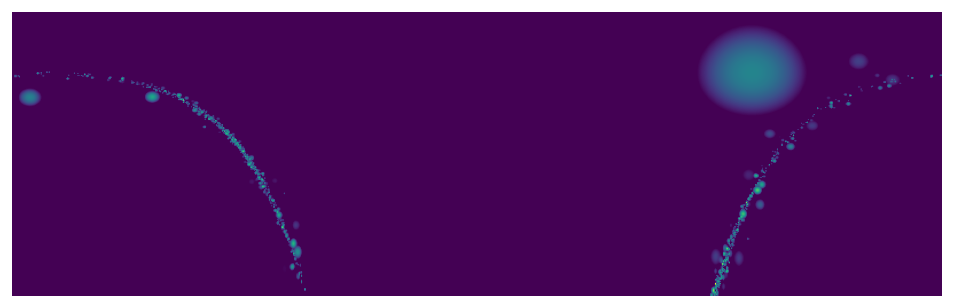

In [48]:
for i in tqdm(range(100)):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(np.flipud(np.log10(np.clip(zs[i], 1e-9, None))),
              extent=(180, -180, -20, 90), vmin=-9, vmax=-4)
    ax.axis('off')
    fig.savefig(f"../outputs/plot_graveyard_samples/{i}.png", pad_inches=0.)
    if i != 99:
        plt.close()

In [49]:
import glob
from PIL import Image

def create_gif_from_pngs(directory, output_path):
    png_files = glob.glob(directory + '/*.png')
    images = []

    for file in png_files:
        image = Image.open(file)
        images.append(image)

    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

directory_path = '../outputs/plot_graveyard_samples'
output_path = '../outputs/graveyard_samples.gif'

create_gif_from_pngs(directory_path, output_path)

## TMP